In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import eurostat
import matplotlib.pyplot as plt
import plotly.express as px
import pycountry
import pickle
import networkx as nx

plt.style.use("ggplot")

%load_ext jupyter_black

In [2]:
import pycountry

list_EU_countries = [
    "Austria",
    "Belgium",
    "Bulgaria",
    "Croatia",
    "Cyprus",
    "Czechia",
    "Denmark",
    "Estonia",
    "Finland",
    "France",
    "Germany",
    "Greece",
    "Hungary",
    "Ireland",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Malta",
    "Netherlands",
    "Poland",
    "Portugal",
    "Romania",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Sweden",
]

dict_EU_countries = {}
for country_name in list_EU_countries:
    country_code = pycountry.countries.get(name=country_name).alpha_2
    country_code = country_code.replace("GR", "EL")
    dict_EU_countries[country_code] = country_name

In [3]:
dataset_code = "nrg_cb_rw"
dict_siec = eurostat.get_dic(dataset_code, "siec", frmt="dict")
dict_nrg = eurostat.get_dic(dataset_code, "nrg_bal", frmt="dict")

# Grouping

## Linking

In [4]:
def create_link_data(path="data/Energy-Balance-Formulas.xlsx"):
    """Return link data between energy categories (needed later to avoid double counting)"""
    # Link data
    df_link = pd.read_excel(
        "data/Energy-Balance-Formulas.xlsx", sheet_name="PRODUCTS_TEXT", header=None
    )
    df_link = df_link.drop([2, 3], axis=1)
    df_link = df_link.ffill()
    df_link = df_link.apply(lambda x: x.str.strip())
    df_link.columns = ["Parent_name", "Parent_code", "Child_code", "Child_name"]
    df_link = df_link[["Parent_name", "Parent_code", "Child_name", "Child_code"]]
    df_link.columns = pd.MultiIndex.from_product(
        [["Parent", "Child"], ["Name", "Code"]]
    )
    return df_link

In [5]:
df_link = create_link_data()
df_link.head()

Parent                                                     Child  \
    Name   Code                                               Name   
0  Total  TOTAL                                 Solid fossil fuels   
1  Total  TOTAL                                 Manufactured gases   
2  Total  TOTAL                             Peat and peat products   
3  Total  TOTAL                            Oil Shale and Oil Sands   
4  Total  TOTAL  Oil and petroleum products (excluding biofuel ...   

                    
              Code  
0  C0000X0350-0370  
1       C0350-0370  
2            P1000  
3            S2000  
4        O4000XBIO

## Digraph

In [6]:
DG = pickle.load(open("data/DG.pickle", "rb"))
DG

In [7]:
list_blocked = [
    "Wind",
    "Hydro",
    "Primary solid biofuels",
    "Fuel oil",
    "Gas oil and diesel oil (excluding biofuel portion)",
    "Natural gas",
    "Biogases from anaerobic fermentation",
    "Biogases",
]

dict_siec_to_code = {value: key for (key, value) in dict_siec.items()}

In [8]:
def get_child_energies(
    DG,
    source="Electricity",
    list_blocked=list_blocked,
    depth_limit=None,
):
    """This function return a list of child energies without their parent to avoid double counting"""
    # Return a dictionary of successors from the source with a defined depth
    dict_successors = nx.dfs_successors(
        G=DG.reverse(),
        source=dict_siec_to_code[source],
        depth_limit=depth_limit,
    )
    # Rename the code into names
    dict_successors = {
        dict_siec[key]: [dict_siec[value] for value in values]
        for key, values in dict_successors.items()
    }
    # Initialise the list with source
    list_energies = [source]
    # Iterate of successors and add child while removing parent to avoid double counting
    for parent, child in dict_successors.items():
        if parent not in list_blocked:
            list_energies.remove(parent)
            list_energies += child
            list_energies = list(set(list_energies))
    return list_energies

# Plot

list_dataset_code = [
    "NRG_CB_RW",
    "NRG_IND_URTD",
    "NRG_INF_LBPC",
    "NRG_BAL_C",
]

## NRG_CB_RW

In [39]:
dataset_code = "NRG_CB_RW"

In [40]:
ds = xr.open_dataarray(f"data/{dataset_code}.nc")
ds

<xarray.DataArray (nrg_bal: 109, Energy: 20, Country: 43, Year: 33)> Size: 25MB
[3093420 values with dtype=float64]
Coordinates:
  * nrg_bal  (nrg_bal) object 872B 'Change in stock' ... 'Transformation inpu...
  * Country  (Country) object 344B 'AL' 'AT' 'BA' 'BE' ... 'TR' 'UA' 'UK' 'XK'
  * Year     (Year) datetime64[ns] 264B 1990-01-01 1991-01-01 ... 2022-01-01
  * Energy   (Energy) object 160B 'Ambient heat (heat pumps)' ... 'Wood pellets'
    unit     object 8B ...
    freq     object 8B ...

In [41]:
list_energies = get_child_energies(
    DG=DG, source="Primary solid biofuels", list_blocked=[]
)
list_energies.append("Wood pellets")
list_energies = sorted(list_energies)
list_energies

['Animal waste',
 'Bagasse',
 'Black liquor',
 'Fuelwood, wood residues and byproducts',
 'Other vegetal material and residues',
 'Renewable fraction of industrial waste',
 'Wood pellets']

### Plot over energies

In [59]:
dfp = df_link.set_index(("Child", "Name"))
for col in ["Fuelwood, wood residues and byproducts", "Wood pellets"]:
    dfp.loc[col, ("Parent", "Name")] = "Primary solid biofuels"
dfp = dfp.loc[ds.Energy.values]
dfp["value"] = (
    ds.sel(Country="EU27_2020", nrg_bal="Indigenous production", Year="2022")
    .drop(["nrg_bal", "Country", "Year"])
    .squeeze()
    .to_dataframe("value")
    .value
)
dfp = dfp.reset_index().drop("Code", axis=1, level=1).droplevel(1, axis=1)
dfp = dfp.set_index("Child")
total = 0
for subtotal_cat in ["Biofuels", "Renewables and biofuels"]:
    list_child = get_child_energies(DG=DG, source=subtotal_cat, list_blocked=[])
    list_child = [child for child in list_child if child in ds.Energy.values]
    value = dfp.loc[list_child].value.sum()
    total += value
    dfp.loc[subtotal_cat] = ["All renewable", value]

dfp.loc["All renewable"] = ["", 0]
dfp2 = dfp.groupby("Child").sum()[["value"]]
dfp2 = dfp2.reset_index()
dfp2["Parent"] = dfp2.Child.replace(dfp.Parent.to_dict())
dfp2

/tmp/ipykernel_36412/2540535996.py:7: DeprecationWarning:

dropping variables using `drop` is deprecated; use drop_vars.



,Child,value,Parent
0,All renewable,0.000,
1,Ambient heat (heat pumps),695913.075,Renewables and biofuels
2,Animal waste,8395.123,Primary solid biofuels
3,Bagasse,26888.108,Primary solid biofuels
4,Biofuels,4769055.896,All renewable
5,Biogases,1330101.996,Biofuels
6,Biogases from anaerobic fermentation,660287.728,Biogases
7,Biogases from thermal processes,4752.896,Biogases
8,Black liquor,554032.876,Primary solid biofuels
9,"Fuelwood, wood residues and byproducts",3258583.596,Primary solid biofuels


In [50]:
dfp2.Child.unique()

array(['All renewable', 'Ambient heat (heat pumps)', 'Animal waste',
       'Bagasse', 'Biofuels', 'Biogases',
       'Biogases from anaerobic fermentation',
       'Biogases from thermal processes', 'Black liquor',
       'Fuelwood, wood residues and byproducts', 'Geothermal',
       'Industrial waste (non-renewable)', 'Landfill gas',
       'Non-renewable municipal waste',
       'Other biogases from anaerobic fermentation',
       'Other vegetal material and residues', 'Primary solid biofuels',
       'Renewable fraction of industrial waste',
       'Renewable municipal waste', 'Renewables and biofuels',
       'Sewage sludge gas', 'Solar thermal', 'Wood pellets'], dtype=object)

In [51]:
parent = "Renewables and biofuels"
dfp2[dfp2.Parent == parent].Child.values

array(['Ambient heat (heat pumps)', 'Geothermal'], dtype=object)

In [61]:
dfp3 = dfp2.set_index("Child").loc[
    [
        "All renewable",
        "Biofuels",
        "Renewables and biofuels",
        "Biogases",
        "Biogases from anaerobic fermentation",
        "Biogases from thermal processes",
        "Landfill gas",
        "Other biogases from anaerobic fermentation",
        "Sewage sludge gas",
        "Ambient heat (heat pumps)",
        "Geothermal",
    ]
]
dfp3 = dfp3.reset_index()
dfp3

,Child,value,Parent
0,All renewable,0.000,
1,Biofuels,4769055.896,All renewable
2,Renewables and biofuels,6833628.512,All renewable
3,Biogases,1330101.996,Biofuels
4,Biogases from anaerobic fermentation,660287.728,Biogases
5,Biogases from thermal processes,4752.896,Biogases
6,Landfill gas,49312.098,Biogases from anaerobic fermentation
7,Other biogases from anaerobic fermentation,560698.439,Biogases from anaerobic fermentation
8,Sewage sludge gas,50277.191,Biogases from anaerobic fermentation
9,Ambient heat (heat pumps),695913.075,Renewables and biofuels


In [53]:
fig = px.sunburst(
    dfp3,
    names="Child",
    parents="Parent",
    values="value",
)
fig.show()

In [67]:
fig = px.sunburst(
    dfp3.iloc[0:7],
    names="Child",
    parents="Parent",
    values="value",
)
fig.show()

In [65]:
dfp3

,Child,value,Parent
0,All renewable,0.000,
1,Biofuels,4769055.896,All renewable
2,Renewables and biofuels,6833628.512,All renewable
3,Biogases,1330101.996,Biofuels
4,Biogases from anaerobic fermentation,660287.728,Biogases
5,Biogases from thermal processes,4752.896,Biogases
6,Landfill gas,49312.098,Biogases from anaerobic fermentation
7,Other biogases from anaerobic fermentation,560698.439,Biogases from anaerobic fermentation
8,Sewage sludge gas,50277.191,Biogases from anaerobic fermentation
9,Ambient heat (heat pumps),695913.075,Renewables and biofuels


In [ ]:
data

In [57]:
data = dict(
    character=["All renewable energy", "Eve", "Seth"],
    parent=["", "Eve", "Eve"],
    value=[total, 14, 12],
)
data = pd.DataFrame(data)
data = data.iloc[[0]]

fig = px.sunburst(data, names="character", parents="parent", values="value")
fig.show()

In [ ]:
data = dict(
    character=["Eve", "Cain", "Seth", "Enos", "Noam", "Abel", "Awan", "Enoch", "Azura"],
    parent=["", "Eve", "Eve", "Seth", "Seth", "Eve", "Eve", "Awan", "Eve"],
    value=[10, 14, 12, 10, 2, 6, 6, 4, 4],
)

In [ ]:
df = pd.DataFrame(data)

In [ ]:
data = dict(
    character=["Eve", "Cain", "Seth", "Enos", "Noam", "Abel", "Awan", "Enoch", "Azura"],
    parent=["", "Eve", "Eve", "Seth", "Seth", "Eve", "Eve", "Awan", "Eve"],
    value=[10, 14, 12, 10, 2, 6, 6, 4, 4],
)

fig = px.sunburst(
    data,
    names="character",
    parents="parent",
    values="value",
)
fig.show()

In [ ]:
import plotly.express as px

df = px.data.tips()
fig = px.sunburst(df, path=["day", "time", "sex"], values="total_bill")
fig.show()

In [ ]:
df

In [ ]:
#Sunburst example
dfp = (
    ds.sel(Country="EU27_2020", nrg_bal="Indigenous production", Energy=list_energies)
    .to_dataset("Energy")
    .drop(["nrg_bal", "Country"])
    .to_dataframe()
)

In [ ]:
dfp = (
    ds.sel(Country="EU27_2020", nrg_bal="Indigenous production", Energy=list_energies)
    .to_dataset("Energy")
    .drop(["nrg_bal", "Country"])
    .to_dataframe()
)

### Plot over time

/tmp/ipykernel_36412/3201444038.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(["nrg_bal", "Country"])


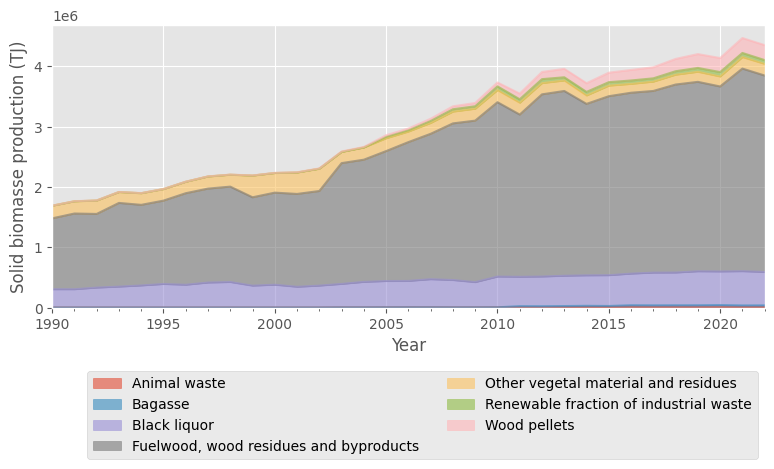

In [13]:
dfp = (
    ds.sel(Country="EU27_2020", nrg_bal="Indigenous production", Energy=list_energies)
    .to_dataset("Energy")
    .drop(["nrg_bal", "Country"])
    .to_dataframe()
)
fig, ax = plt.subplots(figsize=(8, 5))
dfp.plot(ax=ax, kind="area", alpha=0.6, stacked=True)
ax.set_ylabel("Solid biomasse production (TJ)")
ax.legend(bbox_to_anchor=(1, -0.2), ncol=2)
plt.tight_layout()
plt.savefig("plot/figure9.png", bbox_inches="tight")

### Plot over countries

In [14]:
list_countries = [country for country in ds.Country.values if len(country) == 2]
list_energies = get_child_energies(
    DG=DG, source="Primary solid biofuels", list_blocked=[]
)
list_energies.append("Wood pellets")
list_energies

['Fuelwood, wood residues and byproducts',
 'Animal waste',
 'Renewable fraction of industrial waste',
 'Bagasse',
 'Black liquor',
 'Other vegetal material and residues',
 'Wood pellets']

/tmp/ipykernel_36412/3734504445.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(["nrg_bal", "Year"])


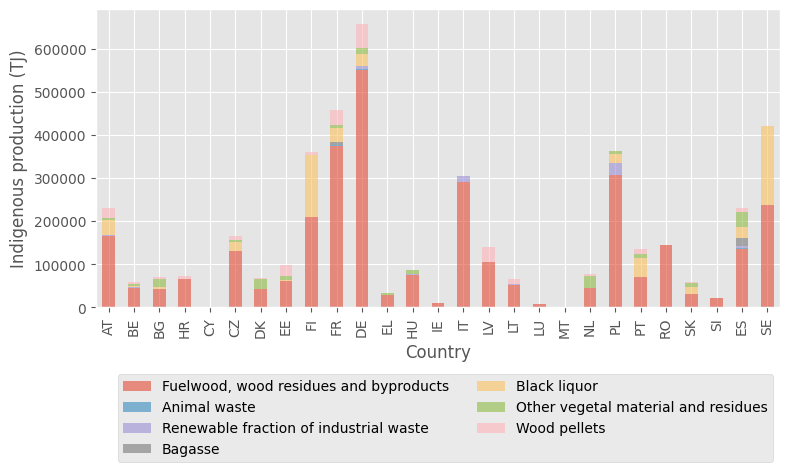

In [15]:
dfp = (
    ds.sel(
        nrg_bal="Indigenous production",
        Country=list(dict_EU_countries.keys()),
        Energy=list_energies,
        Year="2022",
    )
    .squeeze()
    .to_dataset("Energy")
    .drop(["nrg_bal", "Year"])
    .to_dataframe()
)
# dfp = dfp.rename(dict_EU_countries)

fig, ax = plt.subplots(figsize=(8, 5))
dfp.plot(ax=ax, kind="bar", stacked=True, alpha=0.6)
ax.legend(bbox_to_anchor=(1, -0.2), ncol=2)
ax.set_ylabel("Indigenous production (TJ)")
plt.tight_layout()
plt.savefig("plot/figure2.png", bbox_inches="tight")

## NRG_INF_LBPC

In [16]:
dataset_code = "NRG_INF_LBPC"

In [17]:
ds = xr.open_dataarray(f"data/{dataset_code}.nc")
ds

<xarray.DataArray (Energy: 4, Country: 43, Year: 33)> Size: 45kB
[5676 values with dtype=float64]
Coordinates:
  * Country    (Country) object 344B 'AL' 'AT' 'BA' 'BE' ... 'TR' 'UA' 'UK' 'XK'
  * Year       (Year) datetime64[ns] 264B 1990-01-01 1991-01-01 ... 2022-01-01
    plant_tec  object 8B ...
    unit       object 8B ...
  * Energy     (Energy) object 32B 'Other liquid biofuels' ... 'Pure biogasol...
    freq       object 8B ...

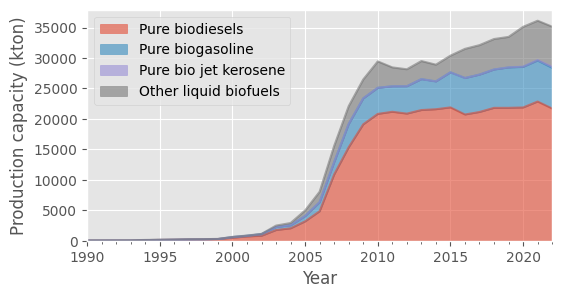

In [18]:
dfp = ds.sel(Country="EU27_2020").to_dataset("Energy").to_dataframe()

fig, ax = plt.subplots(figsize=(6, 3))
dfp[
    [
        "Pure biodiesels",
        "Pure biogasoline",
        "Pure bio jet kerosene",
        "Other liquid biofuels",
    ]
].plot(ax=ax, kind="area", alpha=0.6)
ax.set_ylabel("Production capacity (kton)")
plt.savefig("plot/figure18.png")

##  NRG_IND_URTD

In [19]:
dataset_code = "NRG_IND_URTD"

In [20]:
ds = xr.open_dataarray(f"data/{dataset_code}.nc")
ds

<xarray.DataArray (Energy: 39, nrg_bal: 10, Country: 41, Year: 19)> Size: 2MB
[303810 values with dtype=float64]
Coordinates:
  * Country  (Country) object 328B 'AL' 'AT' 'BA' 'BE' ... 'SK' 'TR' 'UK' 'XK'
  * Energy   (Energy) object 312B 'Biogases' 'Electricity' ... 'Total'
  * Year     (Year) datetime64[ns] 152B 2004-01-01 2005-01-01 ... 2022-01-01
  * nrg_bal  (nrg_bal) object 80B '7% limit - transport target' ... 'Statisti...
    unit     object 8B ...
    freq     object 8B ...

In [21]:
list_energies = [
    "Liquid biofuels",
    "Sustainable biofuels Annex IX, Part A",
    "Sustainable biofuels Annex IX, Part B",
    "Biogases",
]
list_nrg_bal_name = [
    "Final consumption - other transport sector- energy use - Renewable Energy Directive",
    "Final consumption - transport sector - energy use - Renewable Energy Directive",
    "Final consumption - transport sector - rail - energy use - Renewable Energy Directive",
    "Final consumption - transport sector - road - energy use - Renewable Energy Directive",
]
year = "2022"

/tmp/ipykernel_36412/3778144377.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop("Country")


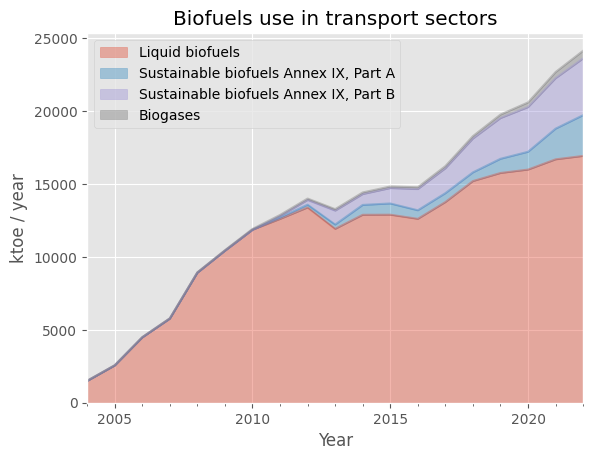

In [22]:
# geo "EU27_2020", "EA20"
dsp = (
    ds.sel(Country="EU27_2020")
    .drop("Country")
    .sel(Energy=list_energies)
    .sel(nrg_bal=list_nrg_bal_name)
).sum(dim="nrg_bal")
dfp = dsp.to_dataset("Energy").to_dataframe()

fig, ax = plt.subplots()
dfp.plot(ax=ax, kind="area", alpha=0.4)
ax.set_ylabel("ktoe / year")
ax.set_title("Biofuels use in transport sectors")
plt.savefig("plot/biofuel_trend.png")

In [23]:
# geo "EU27_2020", "EA20"
dsp = (
    (ds.sel(Energy=list_energies).sel(nrg_bal=list_nrg_bal_name))
    .sum(dim="nrg_bal")
    .sel(Year=year)
    .drop_vars("Year")
    .squeeze()
)
dsp

<xarray.DataArray (Energy: 4, Country: 41)> Size: 1kB
array([[0.0000000e+00, 4.0277200e+02, 0.0000000e+00, 7.6296000e+02,
        1.8609400e+02, 2.4890000e+01, 3.2301500e+02, 2.9576310e+03,
        2.4479000e+02, 1.2559355e+04, 2.8020000e+01, 2.1733200e+02,
        1.4461830e+03, 1.6933841e+04, 5.4495800e+02, 3.0965210e+03,
        0.0000000e+00, 2.1000000e+01, 3.0290000e+02, 2.2963200e+02,
        2.2290000e+01, 1.3890700e+03, 1.1960000e+02, 1.2772000e+02,
        1.5754000e+01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.2609000e+01, 5.7321200e+02, 3.4507900e+02, 1.2034210e+03,
        3.4111000e+02, 5.5868000e+02, 0.0000000e+00, 1.5555860e+03,
        7.9712000e+01, 1.6867000e+02, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.8420000e+01,
        9.5500000e+00, 3.5500000e+00, 4.8454000e+01, 4.6412200e+02,
        1.2660000e+01, 2.4573860e+03, 3.0105000e+01, 0.0000000e+00,
        7.6766300e+02, 2.7989060e+03, 7.7899000e+01, 1.3908400e+02,
        0.0000000e+00, 0.0000000e+00, 3.6800000e+01, 1.8920000e+01,
        1.8600000e+00, 6.1287200e+02, 5.6000000e+00, 3.2550000e+00,
        4.7320000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        7.6100000e-01, 1.6845800e+02, 2.7093000e+01, 2.5070000e+00,
        9.6302000e+01, 0.0000000e+00, 0.0000000e+00, 2.3154900e+02,
...
        1.8160000e+01, 3.0494850e+03, 8.9200000e-01, 3.4873000e+01,
        4.0127900e+02, 3.8921920e+03, 5.7080000e+00, 2.0002300e+02,
        0.0000000e+00, 9.4090000e+00, 1.2730000e+02, 1.8756800e+02,
        0.0000000e+00, 8.5760500e+02, 2.9000000e+00, 4.9773000e+01,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.1846000e+01, 2.9939400e+02, 3.0259400e+02, 2.7448000e+01,
        1.7200400e+02, 0.0000000e+00, 0.0000000e+00, 5.6548500e+02,
        4.1790000e+01, 4.1210000e+01, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [0.0000000e+00, 3.8700000e-01, 0.0000000e+00, 6.0000000e-02,
        0.0000000e+00, 0.0000000e+00, 3.9121000e+01, 9.1273000e+01,
        8.7900000e+00, 3.6123400e+02, 1.2870000e+01, 0.0000000e+00,
        0.0000000e+00, 5.2942400e+02, 2.6518000e+01, 3.6470000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.4500000e-01,
        1.8600000e+00, 1.8486900e+02, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 4.0666000e+01, 3.1841000e+01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.2027900e+02,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00]])
Coordinates:
  * Country  (Country) object 328B 'AL' 'AT' 'BA' 'BE' ... 'SK' 'TR' 'UK' 'XK'
  * Energy   (Energy) object 32B 'Liquid biofuels' ... 'Biogases'
    unit     object 8B 'KTOE'
    freq     object 8B 'A'

In [24]:
def get_country_name(country_code):
    match country_code:
        case "XK":
            country_name = "Kosovo"
        case "EL":
            country_name = "Greece"
        case "UK":
            country_name = "United Kingdom"
        case _:
            country_name = pycountry.countries.get(alpha_2=country_code).name
    return country_name

In [25]:
dsp.to_dataset("Energy").to_dataframe()

,Liquid biofuels,"Sustainable biofuels Annex IX, Part A","Sustainable biofuels Annex IX, Part B",Biogases,unit,freq
Country,,,,,,
AL,0.000,0.000,0.000,0.000,KTOE,A
AT,402.772,0.000,17.992,0.387,KTOE,A
BA,0.000,0.000,0.000,0.000,KTOE,A
BE,762.960,28.420,55.314,0.060,KTOE,A
BG,186.094,9.550,57.339,0.000,KTOE,A
CY,24.890,3.550,19.580,0.000,KTOE,A
CZ,323.015,48.454,46.977,39.121,KTOE,A
DE,2957.631,464.122,640.324,91.273,KTOE,A
DK,244.790,12.660,18.160,8.790,KTOE,A


In [26]:
dfp = dsp.to_dataset("Energy").drop(["unit", "freq"]).to_dataframe()
dfp = dfp.drop(["EU27_2020", "EA20", "UK"])
dfp["Total"] = dfp.sum(axis=1)
dfp = dfp.sort_values("Total", ascending=True)
dfp = dfp.drop("Total", axis=1)

dfp.index = [get_country_name(idx) for idx in dfp.index]
dfp.tail(10)

/tmp/ipykernel_36412/327510859.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  dfp = dsp.to_dataset("Energy").drop(["unit", "freq"]).to_dataframe()


,Liquid biofuels,"Sustainable biofuels Annex IX, Part A","Sustainable biofuels Annex IX, Part B",Biogases
Finland,544.958,77.899,5.708,26.518
Norway,345.079,27.093,302.594,31.841
Belgium,762.960,28.420,55.314,0.060
Netherlands,573.212,168.458,299.394,40.666
Poland,1203.421,2.507,27.448,0.000
Sweden,1555.586,231.549,565.485,120.279
Spain,1446.183,767.663,401.279,0.000
Italy,1389.070,612.872,857.605,184.869
France,3096.521,139.084,200.023,3.647
Germany,2957.631,464.122,640.324,91.273


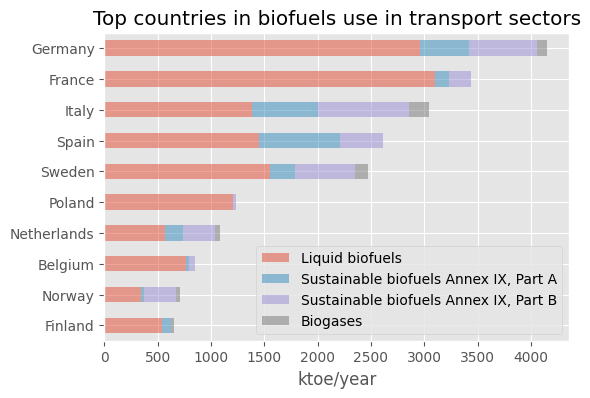

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))
dfp.iloc[-10:].plot(kind="barh", stacked=True, ax=ax, alpha=0.5)
ax.set_xlabel("ktoe/year")
ax.set_title("Top countries in biofuels use in transport sectors")
fig.savefig("plot/top_countries.png", bbox_inches="tight")

## NRG_BAL_C

In [28]:
dataset_code = "NRG_BAL_C"

In [29]:
ds = xr.open_dataarray(f"data/{dataset_code}.nc")
ds

<xarray.DataArray (nrg_bal: 3, Energy: 69, Country: 41, Year: 33)> Size: 2MB
[280071 values with dtype=float64]
Coordinates:
  * Energy   (Energy) object 552B 'Bioenergy' ... 'Pure bio jet kerosene'
  * Country  (Country) object 328B 'AL' 'AT' 'BA' 'BE' ... 'TR' 'UA' 'UK' 'XK'
  * Year     (Year) datetime64[ns] 264B 1990-01-01 1991-01-01 ... 2022-01-01
  * nrg_bal  (nrg_bal) object 24B 'Final consumption - transport sector - ene...
    unit     object 8B ...
    freq     object 8B ...

In [30]:
ds.unit

<xarray.DataArray 'unit' ()> Size: 8B
[1 values with dtype=object]
Coordinates:
    unit     object 8B ...
    freq     object 8B ...

In [31]:
[energy for energy in ds.Energy.values if "olid" in energy]

['Solid fossil fuels', 'Primary solid biofuels']

/tmp/ipykernel_36412/3117876596.py:16: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(["nrg_bal", "unit", "freq", "Year"])


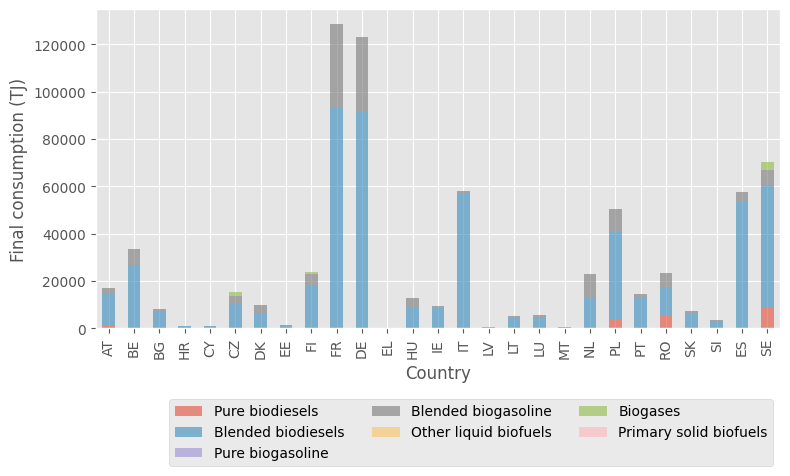

In [32]:
dfp = (
    ds.sel(
        Country=list(dict_EU_countries.keys()),
        Year="2022",
        nrg_bal="Final consumption - transport sector - energy use",
        Energy=[
            "Pure biodiesels",
            "Blended biodiesels",
            "Pure biogasoline",
            "Blended biogasoline",
            "Other liquid biofuels",
            "Biogases",
            "Primary solid biofuels",
        ],
    )
    .drop(["nrg_bal", "unit", "freq", "Year"])
    .squeeze()
    .to_dataset("Energy")
    .to_dataframe()
)

fig, ax = plt.subplots(figsize=(8, 5))
dfp.plot(ax=ax, kind="bar", stacked=True, alpha=0.6)
ax.legend(bbox_to_anchor=(1, -0.2), ncol=3)
ax.set_ylabel("Final consumption (TJ)")
plt.tight_layout()
plt.savefig("plot/figure20.png", bbox_inches="tight")

/tmp/ipykernel_36412/3228419084.py:15: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(["nrg_bal", "unit", "freq"])


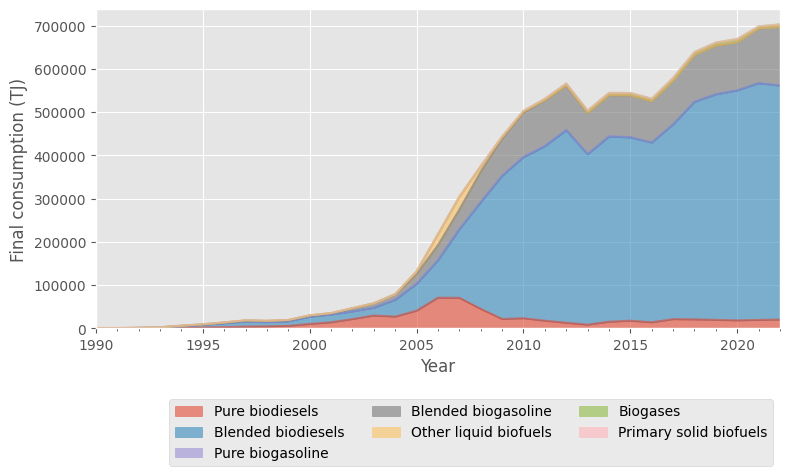

In [33]:
dfp = (
    ds.sel(
        Country="EU27_2020",
        nrg_bal="Final consumption - transport sector - energy use",
        Energy=[
            "Pure biodiesels",
            "Blended biodiesels",
            "Pure biogasoline",
            "Blended biogasoline",
            "Other liquid biofuels",
            "Biogases",
            "Primary solid biofuels",
        ],
    )
    .drop(["nrg_bal", "unit", "freq"])
    .squeeze()
    .to_dataset("Energy")
    .to_dataframe()
)

fig, ax = plt.subplots(figsize=(8, 5))
dfp.plot(ax=ax, kind="area", stacked=True, alpha=0.6)
ax.legend(bbox_to_anchor=(1, -0.2), ncol=3)
ax.set_ylabel("Final consumption (TJ)")
plt.tight_layout()
plt.savefig("plot/figure21.png", bbox_inches="tight")

In [34]:
ds

<xarray.DataArray (nrg_bal: 3, Energy: 69, Country: 41, Year: 33)> Size: 2MB
[280071 values with dtype=float64]
Coordinates:
  * Energy   (Energy) object 552B 'Bioenergy' ... 'Pure bio jet kerosene'
  * Country  (Country) object 328B 'AL' 'AT' 'BA' 'BE' ... 'TR' 'UA' 'UK' 'XK'
  * Year     (Year) datetime64[ns] 264B 1990-01-01 1991-01-01 ... 2022-01-01
  * nrg_bal  (nrg_bal) object 24B 'Final consumption - transport sector - ene...
    unit     object 8B ...
    freq     object 8B ...

/tmp/ipykernel_36412/1024421669.py:16: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(["nrg_bal", "unit", "freq"])


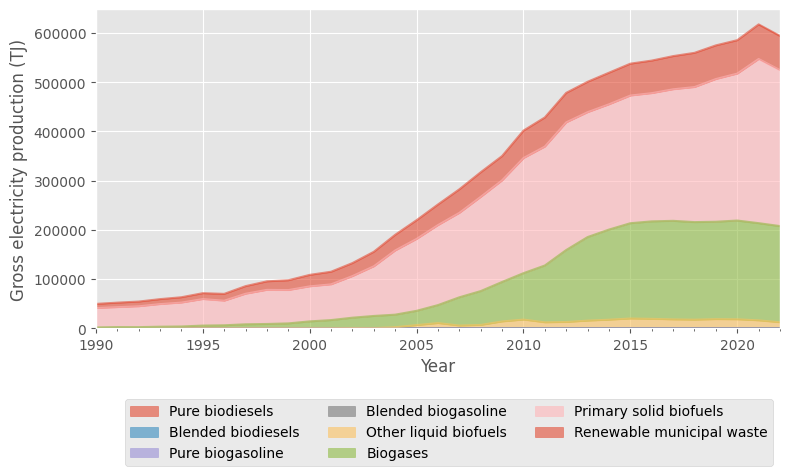

In [35]:
dfp = (
    ds.sel(
        Country="EU27_2020",
        nrg_bal="Gross electricity production",
        Energy=[
            "Pure biodiesels",
            "Blended biodiesels",
            "Pure biogasoline",
            "Blended biogasoline",
            "Other liquid biofuels",
            "Biogases",
            "Primary solid biofuels",
            "Renewable municipal waste",
        ],
    )
    .drop(["nrg_bal", "unit", "freq"])
    .squeeze()
    .to_dataset("Energy")
    .to_dataframe()
)

fig, ax = plt.subplots(figsize=(8, 5))
dfp.plot(ax=ax, kind="area", stacked=True, alpha=0.6)
ax.legend(bbox_to_anchor=(1, -0.2), ncol=3)
ax.set_ylabel("Gross electricity production (TJ)")
plt.tight_layout()
plt.savefig("plot/figure30.png", bbox_inches="tight")

/tmp/ipykernel_36412/3852885582.py:16: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(["nrg_bal", "unit", "freq", "Year"])


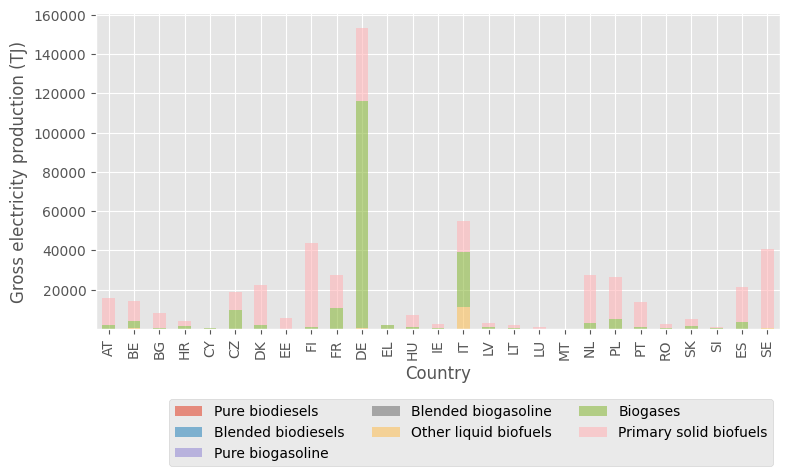

In [36]:
dfp = (
    ds.sel(
        Country=list(dict_EU_countries.keys()),
        Year="2022",
        nrg_bal="Gross electricity production",
        Energy=[
            "Pure biodiesels",
            "Blended biodiesels",
            "Pure biogasoline",
            "Blended biogasoline",
            "Other liquid biofuels",
            "Biogases",
            "Primary solid biofuels",
        ],
    )
    .drop(["nrg_bal", "unit", "freq", "Year"])
    .squeeze()
    .to_dataset("Energy")
    .to_dataframe()
)

fig, ax = plt.subplots(figsize=(8, 5))
dfp.plot(ax=ax, kind="bar", stacked=True, alpha=0.6)
ax.legend(bbox_to_anchor=(1, -0.2), ncol=3)
ax.set_ylabel("Gross electricity production (TJ)")
plt.tight_layout()
plt.savefig("plot/figure29.png", bbox_inches="tight")

/tmp/ipykernel_36412/2764273369.py:16: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(["nrg_bal", "unit", "freq"])


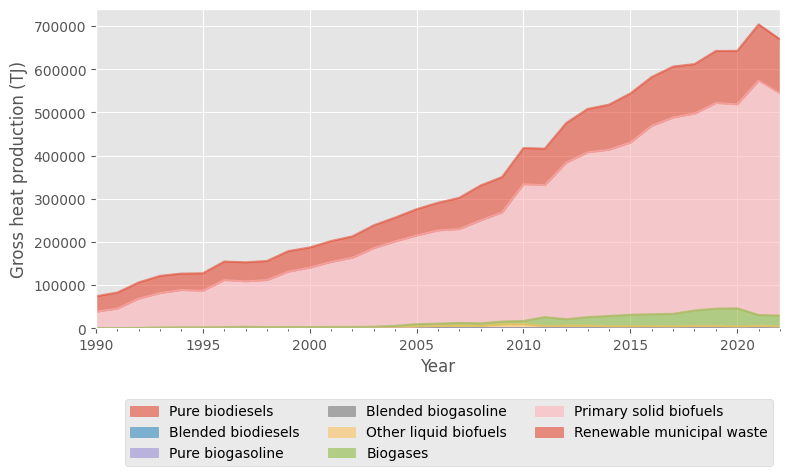

In [37]:
dfp = (
    ds.sel(
        Country="EU27_2020",
        nrg_bal="Gross heat production",
        Energy=[
            "Pure biodiesels",
            "Blended biodiesels",
            "Pure biogasoline",
            "Blended biogasoline",
            "Other liquid biofuels",
            "Biogases",
            "Primary solid biofuels",
            "Renewable municipal waste",
        ],
    )
    .drop(["nrg_bal", "unit", "freq"])
    .squeeze()
    .to_dataset("Energy")
    .to_dataframe()
)

fig, ax = plt.subplots(figsize=(8, 5))
dfp.plot(ax=ax, kind="area", stacked=True, alpha=0.6)
ax.legend(bbox_to_anchor=(1, -0.2), ncol=3)
ax.set_ylabel("Gross heat production (TJ)")
plt.tight_layout()
plt.savefig("plot/figure33.png", bbox_inches="tight")

/tmp/ipykernel_36412/1812594261.py:16: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(["nrg_bal", "unit", "freq", "Year"])


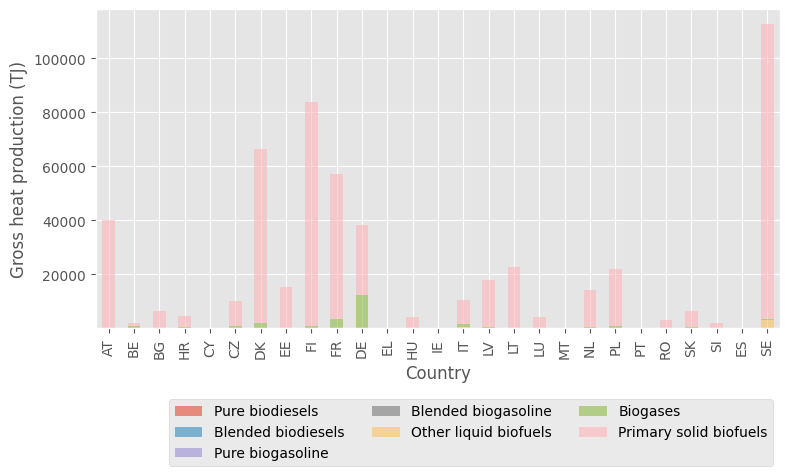

In [38]:
dfp = (
    ds.sel(
        Country=list(dict_EU_countries.keys()),
        Year="2022",
        nrg_bal="Gross heat production",
        Energy=[
            "Pure biodiesels",
            "Blended biodiesels",
            "Pure biogasoline",
            "Blended biogasoline",
            "Other liquid biofuels",
            "Biogases",
            "Primary solid biofuels",
        ],
    )
    .drop(["nrg_bal", "unit", "freq", "Year"])
    .squeeze()
    .to_dataset("Energy")
    .to_dataframe()
)

fig, ax = plt.subplots(figsize=(8, 5))
dfp.plot(ax=ax, kind="bar", stacked=True, alpha=0.6)
ax.legend(bbox_to_anchor=(1, -0.2), ncol=3)
ax.set_ylabel("Gross heat production (TJ)")
plt.tight_layout()
plt.savefig("plot/figure31.png", bbox_inches="tight")